# Introduction 
This is an example of a CANOPUS notebook for visualizing and analyzing compound classes.

First we have to load the canopus package. I wrapped all important stuff into the Canopus class, so the easiest way to work with that (and a somewhat stable api) is to use just this single class.

I also increase the default figure size of matplotlib, just for the case that your default rc parameters are as bad as mine.

In [23]:
import canopus
from canopus import Canopus
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_context("notebook")
%matplotlib inline
plt.rc("figure", figsize=(14,5))

# Processing the data

We will demonstrate the whole processing on a small example of the rosmarine dataset from https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=9a75f69f0f33460293ee3928361ab836.

1. Download all mzml files via ftp download from the Massive dataset. We store the mzml files in the directory rosmarin_mzml
2. Process the data with the SIRIUS 4.4

`sirius -i rosmarin_mzml -o sirius_rosmarin --maxmz=800 lcms-align sirius zodiac fingerid canopus`
- The `--maxmz` option restricts the input data to small compounds. Instead of 800 you can also use smaller or larger values, but computing time of SIRIUS increase exponentially with the mass of the compounds.
- The `lcms-align` option is only necessary if you have multiple LCMS-runs and you want to align them
- This will take some time, but in the end you get the results written into the sirius_rosmarin folder


3. Now we want to process the same data with GNPS. Currently, there is no GNPS output in SIRIUS (I will add that later) but you can use the following ruby script to compute the gnps.mgf and gnps_quant.csv file which are necessary to do feature based molecular networking: https://github.com/kaibioinfo/canopus_treemap/blob/master/tognps.rb

`ruby tognps.rb sirius_rosmarin`
4. You can now upload the mgf and csv file to GNPS and start molecular networking. Download the molecular networking data and extract the archive into a directory with name gnps_rosmarin

Now we can start with the Jupyter notebook analysis. We initialize the Canopus object with the name of the SIRIUS and GNPS folders. I use the short variable name C, because we will use this variable a lot.


In [24]:
C = Canopus(sirius="sirius_rosmarin", gnps="gnps_rosmarin")

# CANOPUS data analysis

## Defining the metadata

The dataset consists of samples and features. The samples can be usually organized in several groups. We call these groups "conditions", but they can be treatments, several tissues, organs, different species and so on. We will first tell CANOPUS which conditions in your data exist and how you can map these conditions to the file names of the samples.

The defineCondition method gets three parameters: first the name of the condition, then a regular expression to detect the filenames of samples having this condition, and finally a color which should be used for this condition in plots. We can leave out the second and third parameter: without a regular expression, all filenames containing the condition name as substring belong automatically to this condition and the color is given automatically, too.

In [25]:
C.defineCondition("Leave", ".*_Leave.*", "brown")
# we can also leave out parameters
C.defineCondition("Flower", color="steelblue")
C.defineCondition("Stem");

To check if we did something wrong, we can output the list of files belonging to a condition

In [26]:
C.condition("Flower").samples

['1BB12_Z5_Flower1_Rosumarinus_BB12_01_26663',
 '1BB7_Z4_Flower2_Rosumarinus_BB7_01_26653',
 '1BC6_Z6_Flower1_Rosumarinus_BC6_01_26670',
 '1BC1_Z5_Flower2_Rosumarinus_BC1_01_26664',
 '1BC7_Z6_Flower2_Rosumarinus_BC7_01_26671',
 '1BB6_Z4_Flower1_Rosumarinus_BB6_01_26652']

## Displaying single compounds

Each feature (or compound) has an ID which is a string (although it is usually numerical). We can list all compounds with the following:

In [27]:
C.compounds

Index(['341', '915', '260', '447', '537', '213', '619', '77', '180', '533',
       ...
       '908', '436', '107', '598', '248', '407', '327', '612', '421', '713'],
      dtype='object', length=619)

If we want to know more about a certain compound, we can use the *featureHeader* method which just tells us the molecular formula identification of the feature, its adduct as well as its ZODIAC score.

In [28]:
C.featureHeader("15")

With gnpsHit we get the result of the GNPS database search for this hit.

In [29]:
C.gnpsHit(15);

,#Scan#,Adduct,CAS_Number,Charge,Compound_Name,Compound_Source,Data_Collector,ExactMass,FileScanUniqueID,INCHI,...,RT_Query,SharedPeaks,Smiles,SpecCharge,SpecMZ,SpectrumFile,SpectrumID,TIC_Query,UpdateWorkflowName,tags
1,15,M+H,NaN,1,caffeic acid-emf,Crude,NaN,0.0,spectra/specs_ms.mgf15,NaN,...,0,6,NaN,1,181.049,spectra/specs_ms.mgf,CCMSLIB00005463719,215744.0,UPDATE-SINGLE-ANNOTATED-BRONZE,


With identification we get the CSI annotation for this hit.

In [30]:
C.identification("15");

,rank,formulaRank,CSI:FingerID_Score,molecularFormula,adduct,InChIkey2D,InChI,name,smiles,xlogp,pubchemids,links
0,1,1,-24.594714,C9H8O4,[M + H]+,QAIPRVGONGVQAS,InChI=1S/C9H8O4/c10-7-3-1-6(5-8(7)11)2-4-9(12)...,Caffeate,C1=CC(=C(C=C1C=CC(=O)O)O)O,NaN,2518;689043;1549111;11458067;16109948;46780148...,HMDB:(1964 3501 125102);ZINC bio:(ZINC00058172...
1,2,1,-116.742108,C9H8O4,[M + H]+,SIUKXCMDYPYCLH,InChI=1S/C9H8O4/c10-7-3-1-2-6(9(7)13)4-5-8(11)...,"2,3-dihydroxycinnamate",C1=CC(=C(C(=C1)O)O)C=CC(=O)O,NaN,193669;5282146;54724355,HMDB:(32057 140954);Natural Products:(UNPD7680...
847,1,1,-121.107975,C9H10O5,[M - H2O + H]+,PAFLSMZLRSPALU,InChI=1S/C9H10O5/c10-6-2-1-5(3-7(6)11)4-8(12)9...,a-Hydroxyhydrocaffeic acid,C1=CC(=C(C=C1CC(C(=O)O)O)O)O,NaN,179536;439435;11600642;21677748;25202033;25203144,HMDB:(3503);ZINC bio:(ZINC00895534 ZINC0089553...
2,3,1,-127.798797,C9H8O4,[M + H]+,YCRJZBXLNHRRPX,InChI=1S/C9H8O4/c10-8-4-3-7(6-9(8)11)2-1-5-13-...,"4-(3-hydroperoxypropa-1,2-dienyl)benzene-1,2-diol",C1=CC(=C(C=C1C=C=COO)O)O,NaN,59704241,PubChem:(59704241)
3,4,1,-128.218472,C9H8O4,[M + H]+,XBRPFOGGNBXDJE,InChI=1S/C9H8O4/c10-5-7(11)3-6-1-2-8(12)9(13)4...,NaN,C1=CC(=C(C=C1C=C(C=O)O)O)O,NaN,NaN,KEGG Mine:(null)
4,5,1,-136.400775,C9H8O4,[M + H]+,WFVBGDQDYLTEJX,InChI=1S/C9H8O4/c10-7-2-1-3-8(11)6(7)4-5-9(12)...,"(E)-3-(2,6-dihydroxyphenyl)prop-2-enoic acid",C1=CC(=C(C(=C1)O)C=CC(=O)O)O,NaN,22323399;66851299,EcoCyc Mine:(null);Natural Products:(UNPD18678...
5,6,1,-137.118011,C9H8O4,[M + H]+,JXIPYOZBOMUUCA,InChI=1S/C9H8O4/c10-7-2-3-8(11)6(5-7)1-4-9(12)...,"2,5-Dihydroxycinnamic acid",C1=CC(=C(C=C1O)C=CC(=O)O)O,NaN,181581;6442618;97114385,HMDB:(134041 140956);Natural Products:(UNPD340...
848,2,1,-137.266816,C9H10O5,[M - H2O + H]+,BUCQPWUTNDGEDF,InChI=1S/C9H10O5/c10-6-2-1-5(3-8(6)12)7(11)4-9...,"3-(3,4-dihydroxyphenyl)-3-hydroxypropanoic acid",C1=CC(=C(C=C1C(CC(=O)O)O)O)O,NaN,20507381;89390372,PubChem:(20507381 89390372);YMDB Mine:(null);K...
6,7,1,-139.092605,C9H8O4,[M + H]+,HGEFWFBFQKWVMY,InChI=1S/C9H8O4/c10-7-3-1-6(8(11)5-7)2-4-9(12)...,ACMC-20aocu,C1=CC(=C(C=C1O)O)C=CC(=O)O,NaN,446611;3359493;23633162;54708747;90657955,HMDB:(126377 132508);KNApSAcK:(38786);Natural ...
7,8,1,-146.458921,C9H8O4,[M + H]+,MFAISHWFCBRFBO,InChI=1S/C9H8O4/c1-5(9(12)13)6-2-3-7(10)8(11)4...,"2-(3,4-dihydroxyphenyl)prop-2-enoic acid",C=C(C1=CC(=C(C=C1)O)O)C(=O)O,NaN,14845485,PubChem:(14845485)


With classification we get the compound classification of this compound.

It outputs the tree with the categories and their probabilities. Categories with high probability are in bold. You can hover with the mouse over the categories to get a tooltip about their meaning.

In [31]:
C.classification("15")

Finally, we might be interested in which samples this feature appears. This can be done with histogram.

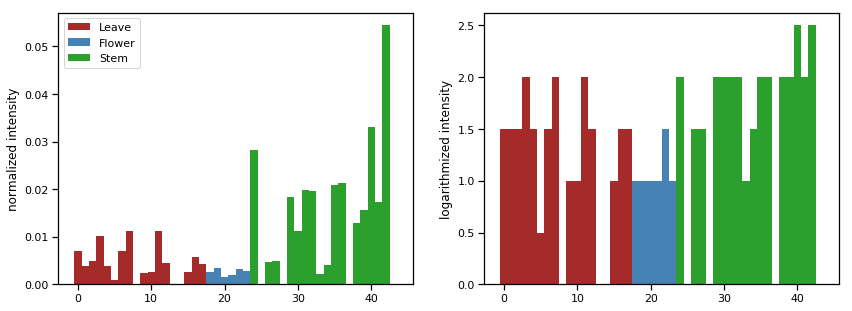

In [32]:
plt.rc("figure", figsize=(14,5))
C.histogram("15")

There are always two plots: Left is the plot of normalized intensities. The normalization is done by:

1. Apply Quantile Normalization. This kind of normalization gives the highest compound in each sample the same intensity, as well as the second highest and so on.
2. Normalize each sample individually, such that the highest compound gets intensity 1.

The resulting quant table can be accessed with `C.QuantNormalized`

There is a second normalization routine which happens after the first one:

1. Add a pseudocount on all intensities (use the 1% quantile of intensities for that)
2. Take the logarithm with base 10 on all intensities
3. Round all values to the next 0.5 number. This results in a very discrete looking dataset where small intensity deviations are removed from data.

The result of the second normalization step can be accessed with `C.QuantLogarithmic`

The plot above shows both normalizations.

We can repeat all steps above in a single command:


,#Scan#,Adduct,CAS_Number,Charge,Compound_Name,Compound_Source,Data_Collector,ExactMass,FileScanUniqueID,INCHI,...,RT_Query,SharedPeaks,Smiles,SpecCharge,SpecMZ,SpectrumFile,SpectrumID,TIC_Query,UpdateWorkflowName,tags
14,283,M+H,437649,1,Spectral Match to Genkwanin from NIST14,Isolated,Data deposited by lfnothias,0.0,spectra/specs_ms.mgf283,NaN,...,0,6,NaN,1,285.076,spectra/specs_ms.mgf,CCMSLIB00003139004,153352.0,UPDATE-SINGLE-ANNOTATED-BRONZE,


,rank,formulaRank,CSI:FingerID_Score,molecularFormula,adduct,InChIkey2D,InChI,name,smiles,xlogp,pubchemids,links
0,1,1,-54.507530,C16H12O5,[M + H]+,JPMYFOBNRRGFNO,InChI=1S/C16H12O5/c1-20-11-6-12(18)16-13(19)8-...,Genkwanin,COC1=CC(=C2C(=C1)OC(=CC2=O)C3=CC=C(C=C3)O)O,NaN,5281617,KNApSAcK:(1043);Natural Products:(UNPD185687);...
1,2,1,-61.042467,C16H12O5,[M + H]+,BQASOSNOLITMSO,InChI=1S/C16H12O5/c1-20-11-6-12(18)16-13(19)8-...,NaN,COC1=CC(=C2C(=C1)OC(=CC2=O)C3=CC(=CC=C3)O)O,NaN,NaN,Natural Products:(UNPD222017);KEGG Mine:(null)
2,3,1,-67.295564,C16H12O5,[M + H]+,DANYIYRPLHHOCZ,InChI=1S/C16H12O5/c1-20-11-4-2-9(3-5-11)14-8-1...,acacetin,COC1=CC=C(C=C1)C2=CC(=O)C3=C(C=C(C=C3O2)O)O,NaN,5280442;25202697,HMDB:(132457);ZINC bio:(ZINC03871358);MeSH:(52...
3,4,1,-74.339999,C16H12O5,[M + H]+,LYRAAKFLFNBVGJ,InChI=1S/C16H12O5/c1-20-11-4-2-3-9(5-11)14-8-1...,"5,7-dihydroxy-2-(3-methoxyphenyl)chromen-4-one",COC1=CC=CC(=C1)C2=CC(=O)C3=C(C=C(C=C3O2)O)O,NaN,5481247,HMDB:(130320);PubChem:(5481247);PubMed:(null)
4,5,1,-79.965080,C16H12O5,[M + H]+,PXFLNHWWYOVFDA,InChI=1S/C16H12O5/c1-20-9-6-12(18)16-13(19)8-1...,Echioidinin,COC1=CC(=C2C(=C1)OC(=CC2=O)C3=CC=CC=C3O)O,NaN,15559079,KNApSAcK:(3816);Natural Products:(UNPD124217);...
5,6,1,-91.078225,C16H12O5,[M + H]+,KQMVAGISDHMXJJ,InChI=1S/C16H12O5/c1-20-11-6-13(18)15-14(7-11)...,Prunetin,COC1=CC(=C2C(=C1)OC=C(C2=O)C3=CC=C(C=C3)O)O,NaN,5281804,HMDB:(34127);KNApSAcK:(2564);Natural Products:...
6,7,1,-91.718592,C16H12O5,[M + H]+,PVJNLMXWZXXHSZ,InChI=1S/C16H12O5/c1-20-10-7-11(17)13-12(8-10)...,Isalpinin,COC1=CC(=C2C(=C1)OC(=C(C2=O)O)C3=CC=CC=C3)O,NaN,5318691,KNApSAcK:(4536);Natural Products:(UNPD23131);P...
7,8,1,-101.949057,C16H12O5,[M + H]+,SWYVZKGICYEZDR,InChI=1S/C16H12O5/c1-20-13-5-3-2-4-10(13)14-8-...,"Flavone, 5,7-dihydroxy-2''-methoxy-",COC1=CC=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O,NaN,5378210,PubChem:(5378210);Natural Products:(UNPD97878)
8,9,1,-105.671314,C16H12O5,[M + H]+,WUADCCWRTIWANL,InChI=1S/C16H12O5/c1-20-11-4-2-9(3-5-11)12-8-2...,Biochanin,COC1=CC=C(C=C1)C2=COC3=CC(=CC(=C3C2=O)O)O,NaN,5280373;11778794;12255048;21673729;25203224;46...,HMDB:(2338);ZINC bio:(ZINC18847037);MeSH:(5280...
9,10,1,-106.914254,C16H12O5,[M + H]+,WCAASHCMRJSIIY,InChI=1S/C16H12O5/c1-8-14(9-2-4-10(17)5-3-9)16...,NaN,CC1=C(C(=O)C2=C(C=C(C=C2O1)O)O)C3=CC=C(C=C3)O,NaN,9965616,PubChem:(9965616);PubMed:(null)


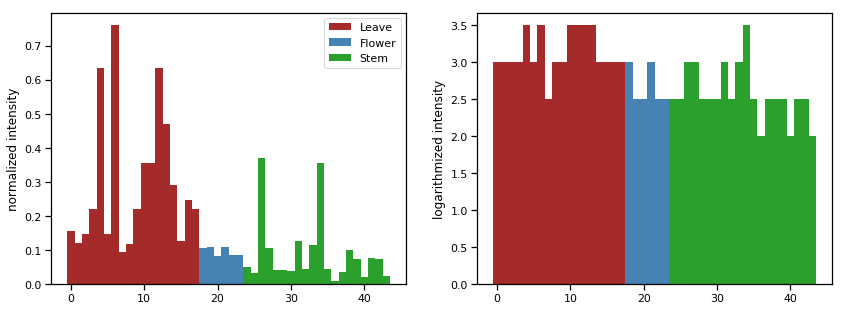

In [34]:
C.describe("283")

# More about  conditions

Before we continue with the next topic, let me give a short explanation about conditions and grouping conditions. We have seen in the last plots, that all conditions we have defined so far are represented in the plot. We can also give a list of conditions to display, though:

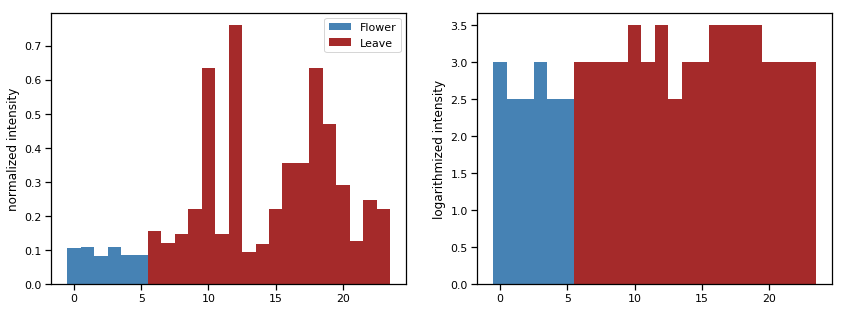

In [35]:
C.histogram("283", ["Flower", "Leave"])

There are two additional methods: **join** and **select**. With join we group conditions together and say "one of these conditions have to be true".

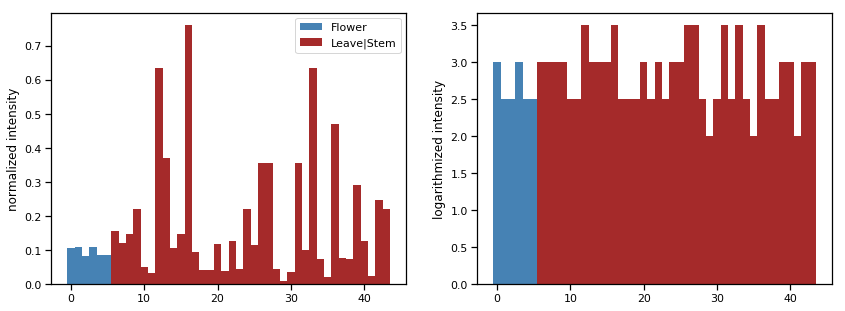

In [36]:
C.histogram("283", ["Flower", C.join("Leave", "Stem")])

In this example it does not make much sense to join the two conditions Leave and Stem. But when we have A LOT of conditions, we might want to plot only a subset of them. Just an example: the mice dataset has two conditions for the treatment (GF and SPF) as well as many conditions for the organs (Mouth, Stomach, and so on). If we want to simplify the plot by merging all organs, which are part of the guts, together, we can use the join method for that. We can also assign a name and a color to it:

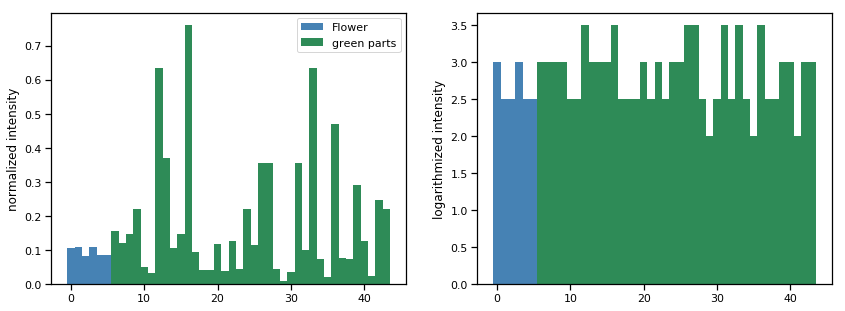

In [38]:
C.histogram("283", ["Flower", C.join("Leave", "Stem",name = "green parts", color="seagreen")])

While **join** is taking the union of all samples of different conditions, **select** is taking the intersection. It does not make sense for this dataset, because we have only distinguished conditions. But for the mouse dataset we could define a group for all samples that are from the germ free mouse and from the guts. We could define such a set as:
`C.select("GF",C.join("Duo","Jeju","Ile","Cecum","Colon"))`

## Displaying a complete dataset

The Sunburst plot allows for visualizing a complete dataset. We can optionally provide a condition for visualization, or just visualize everything. 

In [39]:
C.treemap()

<IPython.core.display.Javascript object>

## Differential analysis

The idea of this kind of analysis is that we want to know, which compound classes are important to differentiate between two conditions. For example: what are the compound classes that are present in Leave but absent in Stem or vice versa.

For finding compound classes which are important to differentiate between the conditions, we proceed the following:

1. order all compounds according to how good they discriminate between the conditions
2. make a permutation test to find out if many of these high discriminating compound classes belong to the same compound class

Because this kind of analysis is quite complex, we first build a new object for differential analysis by calling the differential method. This method gets the two conditions as parameters. If we left out the second condition, all conditions except the first one is used automatically. We save the return value in the variable D.

The last parameter is the ordering method. by default, it is "robust_forest", which is a random forest on the logarithmic data. We can also choose other methods, but let us keep by the default first.

In [40]:
D = C.differential("Leave", "Stem")

## Discriminating compounds

The first thing we might be interested in is the ordering of the compounds. What are the most discriminating compounds.

In [41]:
D.topCompounds();

,weight,category
compound,,
746,0.030228,Alkyl aryl ethers
457,0.025898,Diterpenoids
204,0.024698,Anisoles
121,0.020677,"Nucleosides, nucleotides, and analogues"
213,0.020614,1-benzopyrans
501,0.019846,Prenol lipids
456,0.018705,1-hydroxy-2-unsubstituted benzenoids
455,0.018451,Diterpene lactones
291,0.018239,Lineolic acids and derivatives




The weight column is the feature importance value defined by the random forest. The category column displays **ONE** compound category of the compound. Note, that there might be (and are) other categories, because each compound can have many categories at the same time.

We should check if these compounds are really discriminating:


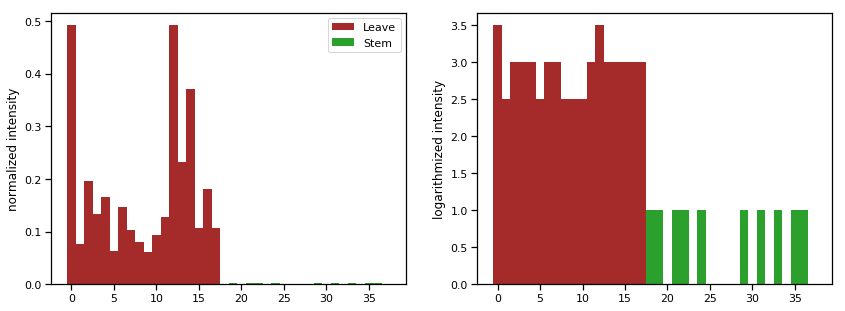

In [42]:
C.histogram("746", ["Leave", "Stem"])

I think this shows quite nice, that the first compound is, indeed, very strongly expressed in leaves but not in stems. We can get more information about this compound as usual. For example with the second compound:

,#Scan#,Adduct,CAS_Number,Charge,Compound_Name,Compound_Source,Data_Collector,ExactMass,FileScanUniqueID,INCHI,...,RT_Query,SharedPeaks,Smiles,SpecCharge,SpecMZ,SpectrumFile,SpectrumID,TIC_Query,UpdateWorkflowName,tags


,rank,formulaRank,CSI:FingerID_Score,molecularFormula,adduct,InChIkey2D,InChI,name,smiles,xlogp,pubchemids,links
0,1,1,-148.976558,C19H26O2,[M + H]+,FGQSEIIKUROJJS,InChI=1S/C19H26O2/c1-11(2)14-9-17(20)19(18(21)...,NaN,CC1=CC(C(CC1)C(=C)C)C2=C(C=C(C=C2O)C(C)C)O,NaN,118230608,PubChem:(118230608)
1,2,1,-156.036518,C19H26O2,[M + H]+,REOZWEGFPHTFEI,InChI=1S/C19H26O2/c1-5-6-14-10-17(20)19(18(21)...,Cannabidivarin,CCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O,NaN,91158;9943770;11601669;45783233;88589122;11768...,Natural Products:(UNPD30720);PubChem:(91158 99...
2,3,1,-164.813677,C19H26O2,[M + H]+,PPCRZFBUHBBJPR,InChI=1S/C19H26O2/c1-6-14-13(5)10-17(20)18(19(...,NaN,CCC1=C(C(=C(C=C1C)O)C2C=C(CCC2C(=C)C)C)O,NaN,123741468,PubChem:(123741468)
3,4,1,-165.404065,C19H26O2,[M + H]+,ORIYPICUSOGUOA,InChI=1S/C19H26O2/c1-5-6-14-10-17(20)19(18(21)...,NaN,CCCC1=CC(=C(C(=C1)O)[C@@H]2CC(=CC[C@H]2C(=C)C)C)O,NaN,NaN,Natural Products:(UNPD48583)
4,5,1,-171.841142,C19H26O2,[M + H]+,ICHJMVMWPKLUKT,InChI=1S/C19H26O2/c1-12(2)15-8-7-13(3)9-16(15)...,"1,3-dimethoxy-5-methyl-2-(3-methyl-6-prop-1-en...",CC1=CC(C(CC1)C(=C)C)C2=C(C=C(C=C2OC)C)OC,NaN,9925913;21055524;25886817;40469923,Training Set:(null);PubChem:(9925913 21055524 ...
5,6,1,-174.974751,C19H26O2,[M + H]+,GMGBNHHELLABGY,InChI=1S/C19H26O2/c1-11(2)15-8-7-12(3)9-16(15)...,NaN,CC1=CC(C(CC1)C(=C)C)C2=C(C=C(C(=C2O)C)C)OC,NaN,118687017,PubChem:(118687017)
6,7,1,-178.223770,C19H26O2,[M + H]+,XICPAROTECFRJP,InChI=1S/C19H26O2/c1-11-16-12(9-14(17(11)21)19...,NaN,CC1=C(C(=CC2=CC(=CC(=C12)O)C(C)(C)C)C(C)(C)C)O,NaN,134876752,PubChem:(134876752)
7,8,1,-179.394571,C19H26O2,[M + H]+,OUKXNLLWLJYLNF,InChI=1S/C19H26O2/c1-5-7-8-9-10-13-16(12-6-2)1...,NaN,CCCCCC#CC(CC=C)C1=C(C(=CC=C1)OC)OC,NaN,101374317,PubChem:(101374317)
8,9,1,-179.625543,C19H26O2,[M + H]+,CSMRKHOSNNLKFM,InChI=1S/C19H26O2/c1-3-5-7-9-15-12-14(8-6-4-2)...,"7-butyl-5-pentylnaphthalene-1,2-diol",CCCCCC1=C2C=CC(=C(C2=CC(=C1)CCCC)O)O,NaN,21033350,PubChem:(21033350)
9,10,1,-182.399727,C19H26O2,[M + H]+,CDGOSXHOMFZLSF,InChI=1S/C19H26O2/c1-5-6-14-10-15(20)11-18(21)...,4-(3-methyl-6-prop-1-en-2-ylcyclohex-2-en-1-yl...,CCCC1=CC(=CC(=C1C2C=C(CCC2C(=C)C)C)O)O,NaN,11522071;88589121,PubChem:(11522071 88589121)


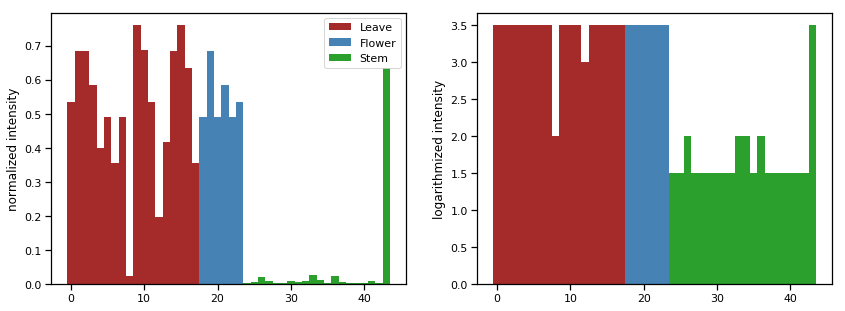

In [44]:
C.describe(457)

This compound is not found in the GNPS spectral libraries. That's why the GNPS search results are empty. We still get useful CANOPUS annotations.

## Discriminating compound categories

Now we want to know: what are the most differentiating compound categories.

In [45]:
D.topCategories();

,pvalue
Methyl esters,1.476462e-07
Tetrahydrofurans,5.008450e-05
Lactones,9.154905e-05
Carboxylic acid esters,3.603722e-04
Tricarboxylic acids and derivatives,4.818830e-04
Furanoid lignans,7.774176e-04
Carbonyl compounds,8.047712e-04
Ketones,1.033818e-03
Naphthalenes,1.987229e-03
Cyclic ketones,2.374433e-03


It is the same idea, this time with compound categories. The p-value column is the output of the permutation test (I haven't added a correction, though, so don't take this value serious).

We might now wonder if Methyl esters are really differential expressed in both classes. We can use heatmaps to find out:

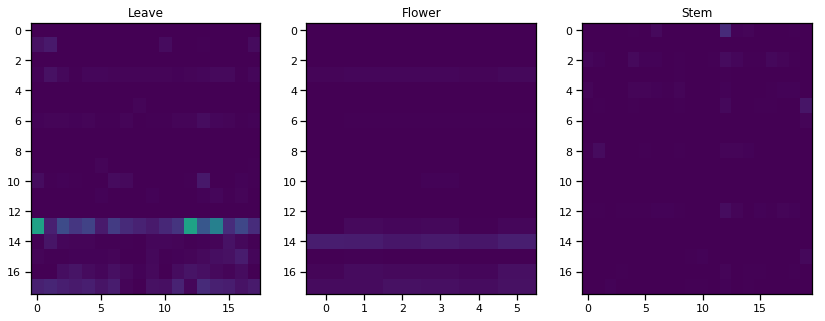

In [47]:
C.heatmap("Methyl esters")

The rows in this plot are the compounds, the columns are the samples. The color coding goes from low intensity (dark blue) to high intensity (yellow).

Okay, we see that there are many compounds in Stem belonging to the Methyl esters class and which are lower expressed in leave and vice versa. We also see, that one compound is very highly expressed in leave.

What are the other methods for discrimination? First, we can use random forest on the normalization data using the "forest" keyword. With the "fold_change" keyword we look for classes which are differential expressed just by looking at the trimmed mean fold change between the samples.

In [48]:
D = C.differential("Flower", method="fold_change")

In [49]:
D.topCategories();

,pvalue
Phenoxy compounds,4.817589e-08
Methoxybenzenes,6.424683e-07
Anisoles,1.913971e-06
Acetals,8.312548e-06
Phenolic glycosides,1.384877e-05
Phenol ethers,1.544391e-05
Alkyl aryl ethers,4.325835e-05
Glycosyl compounds,6.996126e-05
Ethers,8.091262e-05
Benzoyl derivatives,2.486977e-04


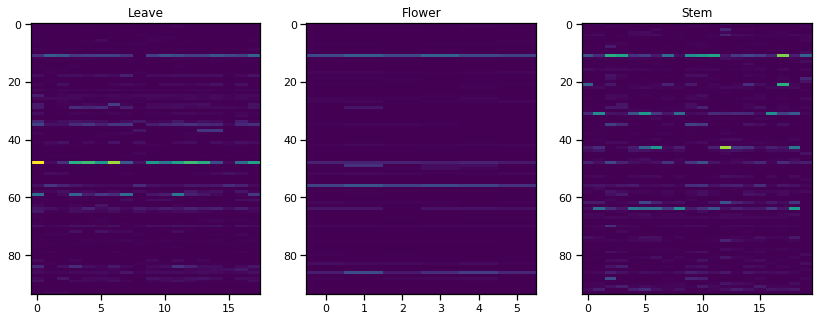

In [50]:
C.heatmap("Phenoxy compounds")

With **differentialTreemap** we can draw two sunburst plots which compare two conditions.

In [56]:
C.differentialTreemap("Flower", "Leave")

<IPython.core.display.Javascript object>

## Using autocompletion for compound names, category names and conditions

If you want to know the expression of a certain category, you can use the autocompletion of Jupyter notebook. Let us assume we want to make a heatmap of flavonoids, but we do not exactly know how this category is written. We can just write

`C["Fl`

and then press [TAB] and the remaining name is autocompleted. This is also working with conditions and compound ids.

# Molecular Network analysis

In the following we take a look how we can take advantage from the GNPS molecular networking information.

First, we can query the GNPS hits by compound categories (although that is not very exciting):

In [57]:
C.gnpsHit(category="Flavonoids");

,#Scan#,Adduct,CAS_Number,Charge,Compound_Name,Compound_Source,Data_Collector,ExactMass,FileScanUniqueID,INCHI,...,RT_Query,SharedPeaks,Smiles,SpecCharge,SpecMZ,SpectrumFile,SpectrumID,TIC_Query,UpdateWorkflowName,tags
2,154,[M+H]+,NaN,1,cirsimarin,isolated,MoNA:VF-NPL-QTOF000060,0.000,spectra/specs_ms.mgf154,InChI=1S/C23H24O11/c1-30-15-8-14-17(19(27)22(1...,...,0,7,NaN,1,477.139,spectra/specs_ms.mgf,CCMSLIB00004717545,1604580.0,UPDATE-SINGLE-ANNOTATED-BRONZE,
4,171,Cat,68795379,1,Spectral Match to Peonidin 3-O-glucoside catio...,Isolated,Data deposited by lfnothias,0.000,spectra/specs_ms.mgf171,NaN,...,0,6,NaN,1,463.122,spectra/specs_ms.mgf,CCMSLIB00003138497,832232.0,UPDATE-SINGLE-ANNOTATED-BRONZE,
9,228,M-H2O+H,NaN,1,"NCGC00179950-02!(2R,3R)-2-(3,4-dihydroxyphenyl...",isolated,lfnothias,318.074,spectra/specs_ms.mgf228,InChI=1S/C16H14O7/c1-22-8-5-11(19)13-12(6-8)23...,...,0,6,COC1=CC2=C(C(=O)[C@H](O)[C@H](O2)C3=CC(O)=C(O)...,1,301.070,spectra/specs_ms.mgf,CCMSLIB00000848384,33692.0,UPDATE-SINGLE-ANNOTATED-GOLD,
14,283,M+H,437649,1,Spectral Match to Genkwanin from NIST14,Isolated,Data deposited by lfnothias,0.000,spectra/specs_ms.mgf283,NaN,...,0,6,NaN,1,285.076,spectra/specs_ms.mgf,CCMSLIB00003139004,153352.0,UPDATE-SINGLE-ANNOTATED-BRONZE,
43,65,[M+H]+,NaN,1,neoeriocitrin,isolated,MoNA:VF-NPL-QTOF000412,0.000,spectra/specs_ms.mgf65,InChI=1S/C27H32O15/c1-9-20(33)22(35)24(37)26(3...,...,0,16,NaN,1,597.181,spectra/specs_ms.mgf,CCMSLIB00004717940,21904.0,UPDATE-SINGLE-ANNOTATED-BRONZE,


Note that the query is using the canopus annotations for the category. Thus, all GNPS hits in this table are annotated by CANOPUS as Flavonoids.

Now, let us take a look into the molecular networks themself:

In [58]:
C.molecularNetwork()

<IPython.core.display.Javascript object>

The first view shows the complete network, but it is currently too large to be useful. So we should click first on the Display subnetwork button below. Now we can scroll through all the GNPS networks for this dataset. The majority category above tells us which compound category is dominant in this cluster. Furthermore, all nodes belonging to this category are highlighted red. We can also click on a node and see its classification.

If we click on the name of any compound class, the highlighting changes such that we see which nodes belong to this class. We can inspect the original network by clicking on the view network in GNPS link below.

Note that the Majority Class is currently very primitive: it just uses the class deepest in the tree which occurs for more than 50% of the network. However, often this is not the most interesting class.

GNPS hits are highlighted in orange. So, click through the network to find a cluster which is not annotated yet! This might be the interesting one where canopus annotation can help.


## Explore data with Cytoscape

The builtin network viewer is rather simple. For a better exploration of the network we recommend the Cytoscape software. To convert the CANOPUS results into a graphml file, use the **exportCytoscape** function. We can call this function with a list of manually selected class names, or let CANOPUS decide which classes might be interesting for annotation. GraphML files are table based, while ClassyFire annotations are a directed acyclic graph. So we need some way for assigning single classes to a node, although reality is more complex. For best visualuation results we recommend to manually assign useful compound classes.

In [59]:
C.exportCytoscape("file1.graphml")
C.exportCytoscape("file2.graphml", [C["Prenol lipids"], C["Flavonoids"], C["Amino acids, peptides, and analogues"], 
                                    C["Benzene and substituted derivatives"]])